# 残差を確認してモデルを改善する
　今回は, 作成したモデルを改善する方法として, 「残差を確認する」を紹介する. 作成したモデルが苦手とする予測対象を確認することで, どのような特徴量の追加が必要か, または学習の仕方やモデル自体の変更などが必要な場合の示唆を得ることができる.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

## データ読み込み

In [2]:
from pathlib import Path
input_dir = Path('../input_data/jleague')

In [3]:
# train + train_add
train = pd.read_csv(input_dir / 'train.csv')
train_add = pd.read_csv(input_dir / 'train_add.csv')
train = pd.concat([train, train_add], ignore_index=True).sort_values('id')

# condition + condition_add
condition = pd.read_csv(input_dir / 'condition.csv')
condition_add = pd.read_csv(input_dir / 'condition_add.csv')
condition = pd.concat([condition, condition_add], ignore_index=True).sort_values('id')

# stadium
stadium = pd.read_csv(input_dir / 'stadium.csv')

# test
test = pd.read_csv(input_dir / 'test.csv')
test_add = pd.read_csv(input_dir / '2014_add.csv')

In [4]:
# train + condition + stadium
train = (
    train
    .merge(condition, on='id', how="left")
    .merge(stadium.rename(columns={"name":"stadium"}), on='stadium', how="left")
)

# test + condition + stadium
test = (
    test
    .merge(condition, on='id', how="left")
    .merge(stadium.rename(columns={"name":"stadium"}), on='stadium', how="left")
)


## モデル構築(改善前)
- `capa` のみ

In [5]:
X = train[['capa']]
y = train['y']

In [6]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_X, train_y)

In [8]:
train_pred = model.predict(train_X)
valid_pred = model.predict(valid_X)

## 評価指標の定義
RMSEを使用する
$$
RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N\left(y_{predicted}^{(i)}-y_{actual}^{(i)}\right)^2}
$$

In [9]:
def rmse(y_actual, y_predicted):
    return np.sqrt(np.mean((y_predicted - y_actual) ** 2))

In [10]:
# (5853.347792718457, 6106.454072467924)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)

(np.float64(5853.347792718457), np.float64(6106.454072467924))

sklearnを使用すると下記のように書くことができる.

In [11]:
from sklearn.metrics import root_mean_squared_error
(root_mean_squared_error(train_y, train_pred), root_mean_squared_error(valid_y, valid_pred))

(5853.347792718457, 6106.454072467924)

## 残差を見る
- 予測と正解の差が大きいデータを見て、なぜ外しているか考える
  - ここでは全データを見るが、モデル構築データへのフィッティングが十分な場合は検証データのみでOK

In [12]:
train['pred'] = model.predict(X)
train['pred - y'] = train['pred'] - train['y']
train['abs(pred - y)'] = train['pred - y'].abs()

In [13]:
train[['id', 'y', 'pred', 'pred - y', 'abs(pred - y)', 'stage', 'match', 'home', 'away', 'stadium', 'capa']].sort_values('abs(pred - y)', ascending=False).head(50)

,id,y,pred,pred - y,abs(pred - y),stage,match,home,away,stadium,capa
1059,15127,62632,29594.655650,-33037.344350,33037.344350,Ｊ１,第３３節第１日,横浜Ｆ・マリノス,アルビレックス新潟,日産スタジアム,72327
1066,15134,54905,26110.585180,-28794.414820,28794.414820,Ｊ１,第３４節第１日,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,63700
1654,15787,54350,26110.585180,-28239.414820,28239.414820,Ｊ１,第１４節第１日,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,63700
784,14852,52293,26110.585180,-26182.414820,26182.414820,Ｊ１,第２節第１日,浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,63700
1567,15699,0,26110.585180,26110.585180,26110.585180,Ｊ１,第４節第１日,浦和レッズ,清水エスパルス,埼玉スタジアム２００２,63700
298,14292,51879,26110.585180,-25768.414820,25768.414820,Ｊ１,第３４節第１日,浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,63700
1592,15725,42723,19695.727714,-23027.272286,23027.272286,Ｊ１,第７節第２日,セレッソ大阪,ガンバ大阪,ヤンマースタジアム長居,47816
1632,15765,38966,16539.184907,-22426.815093,22426.815093,Ｊ１,第１１節第１日,名古屋グランパス,セレッソ大阪,豊田スタジアム,40000
1016,15084,47790,26110.585180,-21679.414820,21679.414820,Ｊ１,第２８節第１日,浦和レッズ,大宮アルディージャ,埼玉スタジアム２００２,63700
866,14934,46649,26110.585180,-20538.414820,20538.414820,Ｊ１,第１１節第１日,浦和レッズ,鹿島アントラーズ,埼玉スタジアム２００２,63700


### 発見1: `y=0` の試合がある
- **対処**: 異常値として学習データから除去する
- **参考**: [浦和レッズ差別横断幕事件](https://ja.wikipedia.org/wiki/%E6%B5%A6%E5%92%8C%E3%83%AC%E3%83%83%E3%82%BA%E5%B7%AE%E5%88%A5%E6%A8%AA%E6%96%AD%E5%B9%95%E4%BA%8B%E4%BB%B6)

### 発見2: 特定の `home` で大きく外している
- **対処**: `home` の情報をモデルに取り入れる

## モデル改善1
- `id=15699` の試合を除去する

In [14]:
train = train[train['id'] != 15699].copy()

In [15]:
X = train[['capa']]
y = train['y']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression().fit(train_X, train_y)
train_pred = model.predict(train_X)
valid_pred = model.predict(valid_X)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)

(np.float64(5853.830717642149), np.float64(5967.2039572683625))

## モデル改善2
- `home` の情報をモデルに取り入れる
  - ダミー変数化して説明変数に加える
- `home` ごとの `y` の平均 (エラーバーは不偏標準偏差) をプロットすると、チームごとの違いがわかる

<Axes: title={'center': 'homeごとのyの平均'}, xlabel='home'>

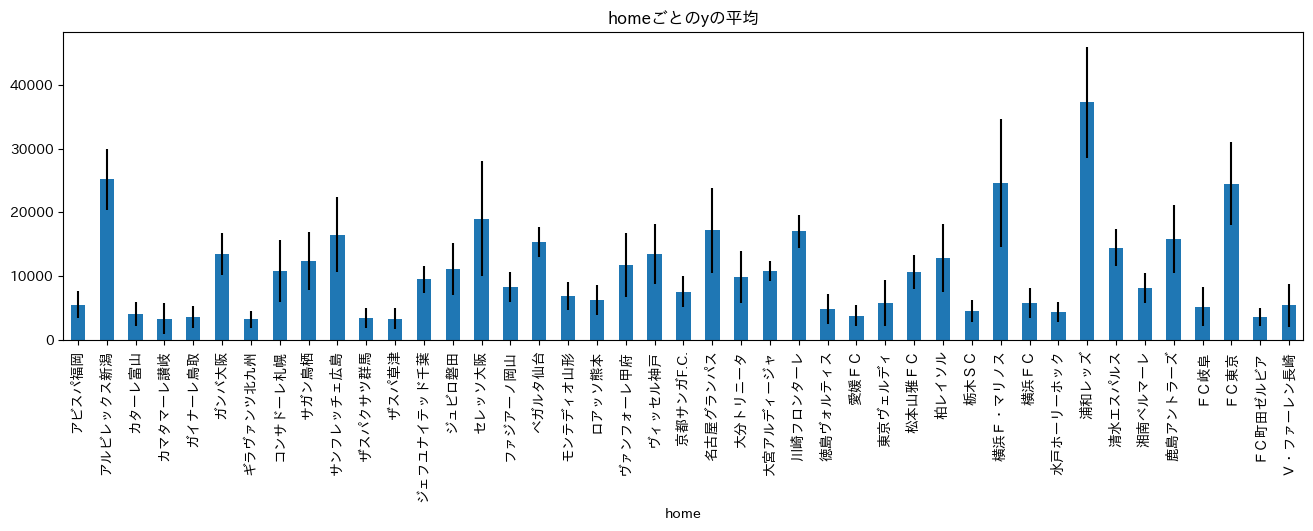

In [16]:
train.groupby('home')['y'].mean().plot.bar(
    yerr=train.groupby('home')['y'].std(), figsize=(16, 4), title='homeごとのyの平均'
)

- train/validに分割すると一部のチームが片方にしか現れないことがわかる
  - Jリーグには昇格/降格があり、trainのみに現れるチームはJ2→J3へ降格、validのみに現れるチームはJ3→J2へ昇格したと考えられる

In [17]:
X = train[['capa', 'home']]
y = train['y']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)

<Axes: title={'center': 'homeごとのtrain/validのデータ数'}, xlabel='home'>

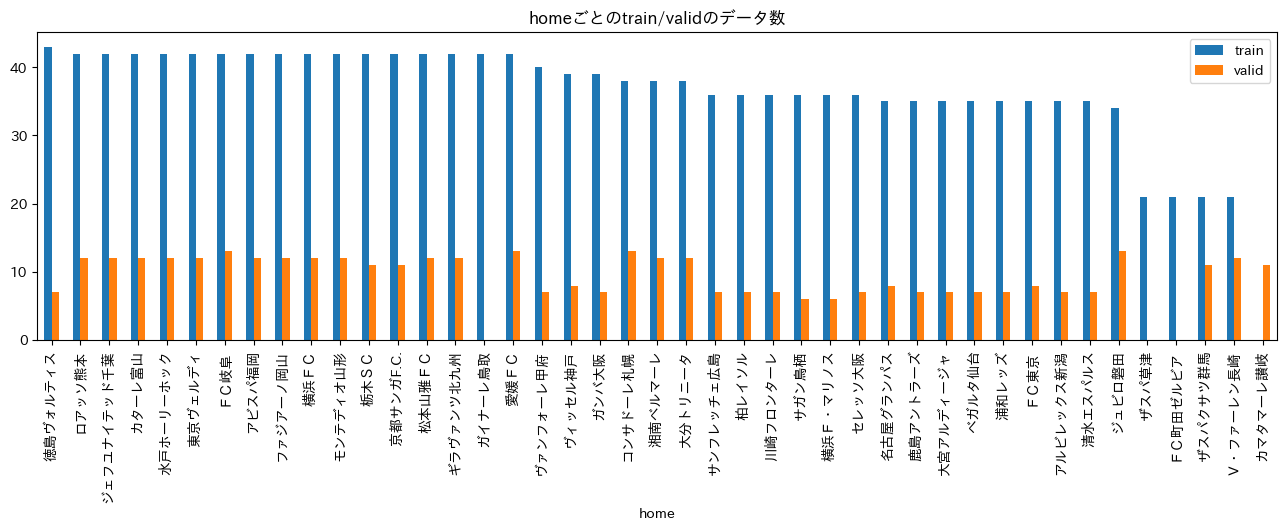

In [18]:
pd.concat([
    train_X['home'].value_counts().rename('train'),
    valid_X['home'].value_counts().rename('valid'),
], axis=1).plot.bar(figsize=(16, 4), title='homeごとのtrain/validのデータ数')

- validのみに現れるチーム(カマタマーレ讃岐)は予測できないので、未知として扱う

In [19]:
train['home'] = train['home'].replace('カマタマーレ讃岐', None)

In [20]:
X = pd.get_dummies(train[['capa', 'home']], drop_first=True)
y = train['y']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression().fit(train_X, train_y)
train_pred = model.predict(train_X)
valid_pred = model.predict(valid_X)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)

(np.float64(3625.4971533393027), np.float64(3794.7563789888854))

## おまけ
- 残差から生まれた仮説ではないが、テレビの放送局数をモデルに組み込んでみる

<Axes: title={'center': 'tv_numごとのyの平均'}, xlabel='tv_num'>

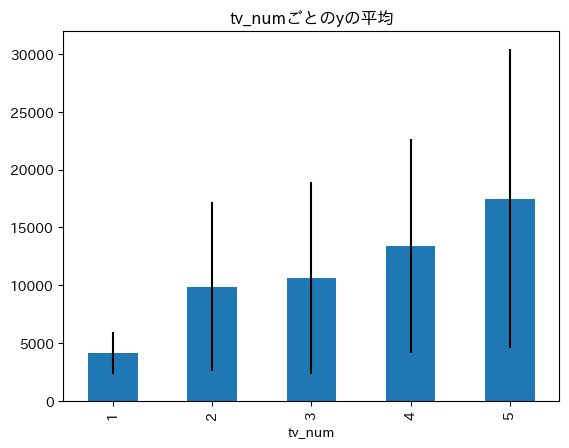

In [21]:
train['tv_num'] = train['tv'].str.count('／') + 1
train.groupby('tv_num')['y'].mean().plot.bar(
    yerr=train.groupby('tv_num')['y'].std(), title='tv_numごとのyの平均'
)

In [22]:
X = pd.get_dummies(train[['capa', 'home', 'tv_num']], drop_first=True)
y = train['y']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression().fit(train_X, train_y)
train_pred = model.predict(train_X)
valid_pred = model.predict(valid_X)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)

(np.float64(3619.9656299607464), np.float64(3781.270380057237))

## 結果のまとめ

| モデル | 学習スコア | 検証スコア |
| ------ | ---------- | ---------- |
| 改善前 | 5853.34    | 6106.45    |
| 改善1  | 5853.83    | 5967.20    |
| 改善2  | 3625.49    | 3794.76    |
| おまけ | 3619.96    | 3781.27    |

> *Note*: 検証データの作り方次第で検証スコアは大きく変わることに注意してください。